# Cyclical Learning Rate
### Reference
1. [Cyclical Learning Rates for Training Neural Networks](https://arxiv.org/abs/1506.01186)


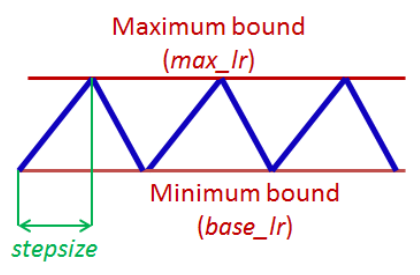

### Step size
If the number of dataset and batch size are 50,000 and 100 respectively, the number of iteration of an epoch is decided to be 500 since 50,000 / 100. The study reveals that ideal `step size` is 2 - 10 times the number of iteration of an epoch.

### Cycle
`stepsize`*2 the number of iteration until learning rate return to minimum bound.

### Update rule
```python
local_cycle = np.floor(1 + epochCounter/(2*stepsize))
local_x = np.abs(epochCounter/stepsize - 2*cycle + 1)
local_lr = minLR + (maxLR - minLR) * np.maximum(0, (1-x))
```
The study suggests above update rule. Adapting it has couple of problems.
1. LR osillitates between 2 values, but it jumps between those values. LR should move back and forth gradually.
2. It doesn't follow the cycle that we defined earlier.

What we actually need is not current epoch but current iteration so that we can calculate an iteration belongs to which cycle.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import callbacks

In [ ]:
max_lr = 5e-1
min_lr = 1e-4
dataset = 50000
batch_size = 256
epochs = 50
iters = int(dataset // batch_size)
step = 5
step_size = iters * step

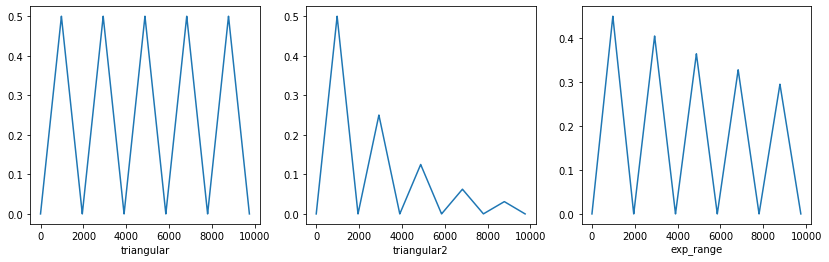

In [ ]:
def triangular2(x):
  return 2**(1-x)

def exp_range(gamma, cycle):
  return gamma**cycle

policies = ['triangular', 'triangular2', 'exp_range']
logs = [[min_lr], [min_lr], [min_lr]]
plt.figure(figsize=(14, 4))
for idx, policy in enumerate(policies):
  cnt = 1
  for epoch in range(1, epochs+1):
    for iter in range(1, iters+1):
      cycle = np.floor(1 + cnt / (2 * step_size))
      x = np.abs(cnt / step_size - 2 * cycle + 1)
      if policy == 'triangular':
        lr = min_lr + (max_lr - min_lr) * np.maximum(0, (1 - x))
      elif policy == 'triangular2':
        lr = min_lr + (max_lr - min_lr) * np.maximum(0, (1 - x)) * triangular2(cycle)
      elif policy == 'exp_range':
        lr = min_lr + (max_lr - min_lr) * np.maximum(0, (1 - x)) * exp_range(0.9, cycle)
      logs[idx].append(lr)
      cnt += 1
  plt.subplot(1, len(policies), idx+1)
  plt.plot(logs[idx])
  plt.xlabel(policy)

## Put these into callback function

In [ ]:
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers
from tensorflow.keras import backend
from tensorflow.keras import datasets
from tensorflow.keras import metrics
from tensorflow.keras import losses

In [ ]:
class CLR(callbacks.Callback):
  '''
  This callback class allows learning rate to go back and forth
  between minimum learning rate and maximum learning rate so that
  a model can learn effectively.

  Args: 
    min_lr  (float): Minimum bound learning rate.
    max_lr  (float): Maximum bound learning rate.
                     Researchers recommend that optimal be 3x or 4x of min_lr.
    step_size (int): It decides length of step size.
                     Typical step size is 2-10 times mini_batch.
    gamma   (float): 
    policy (string): {'triangular', 'triangular2', 'exp_range'}
  '''
  def __init__(self, min_lr, max_lr, gamma=1, step_size:int=2, policy:str='triangular') -> None:
    self.min_lr = min_lr
    self.max_lr = max_lr
    self.gamma = gamma
    self.step_size = step_size
    self.policy = policy
    self.step = None
    self.iter_counter = 1
    self.log = []
       
  def triangular2(self, cycle):
    return 2**(1-cycle)

  def exp_range(self, gamma, cycle):
    return gamma**(cycle)

  def clr(self, gamma:float)->float:
    cycle = np.floor(1 + self.iter_counter / (2 * self.step))
    x = np.abs(self.iter_counter / self.step - 2 * cycle + 1)
    if self.policy == 'triangular':
      return self.min_lr + (self.max_lr - self.min_lr) * np.maximum(0, (1 - x))
    elif self.policy == 'triangular2':
      return self.min_lr + (self.max_lr - self.min_lr) * np.maximum(0, (1 - x)) * self.triangular2(cycle)
    elif self.policy == 'exp_range':
      return self.min_lr + (self.max_lr - self.min_lr) * np.maximum(0, (1 - x)) * self.exp_range(self.gamma, cycle)
    else:
      raise ValueError("Undefined policy. Choose one of triangular, triangular2 and exp_range or Define a new one")
    
  def on_train_begin(self, batch, logs=None):
    iteration = self.params.get('steps')
    self.step = self.step_size * iteration
    if self.min_lr:
      backend.set_value(self.model.optimizer.learning_rate, self.min_lr)

  def on_batch_end(self, batch, logs=None):
    self.iter_counter += 1
    lr = self.clr(self.gamma)
    self.log.append(lr)
    backend.set_value(self.model.optimizer.learning_rate, lr)

  def on_train_end(self, logs=None):
    plt.figure(figsize=(12, 6))
    plt.plot(self.log)
    plt.xlabel('Iteration')
    plt.ylabel('LR')